Ce notebook présente le déroulé de notre algorithme

In [ ]:
ETAPE 1 :
Je sélectionne tous les fichiers que je veux traiter

In [1]:
# Importer les bibliothèques
import numpy as np
import pandas as pd
from obspy import read
from obspy.signal.trigger import classic_sta_lta, trigger_onset
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import signal
import os
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset


# Définir les répertoires
data_directory = 'data/mars/test/data/'  # Chemin vers le dossier contenant les fichiers CSV et MiniSEED
output_directory = 'output/'  # Répertoire pour sauvegarder les résultats

# Créer le répertoire de sortie s'il n'existe pas
os.makedirs(output_directory, exist_ok=True)

# Obtenir la liste des fichiers CSV
csv_files = [f for f in os.listdir(data_directory) if f.endswith('.csv')]
print(csv_files)

['XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.mseed_summary.csv', 'XB.ELYSE.02.BHV.2021-10-11HR23_evid0011.mseed_summary.csv', 'XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.csv', 'XB.ELYSE.02.BHV.2019-07-26HR12_evid0034.mseed_summary.csv', 'XB.ELYSE.02.BHV.2021-05-02HR01_evid0017.csv', 'XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.mseed_summary.csv', 'XB.ELYSE.02.BHV.2021-12-24HR22_evid0007.mseed_summary.csv', 'XB.ELYSE.02.BHV.2019-07-26HR12_evid0033.mseed_summary.csv', 'XB.ELYSE.02.BHV.2022-04-09HR22_evid0002.csv', 'XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.csv', 'XB.ELYSE.02.BHV.2021-10-11HR23_evid0011.csv', 'XB.ELYSE.02.BHV.2022-05-04HR23_evid0001.mseed_summary.csv', 'XB.ELYSE.02.BHV.2022-04-09HR22_evid0002.mseed_summary.csv', 'XB.ELYSE.02.BHV.2019-07-26HR12_evid0033.csv', 'XB.ELYSE.02.BHV.2022-05-04HR23_evid0001.csv', 'XB.ELYSE.02.BHV.2021-05-02HR01_evid0017.mseed_summary.csv', 'XB.ELYSE.02.BHV.2021-12-24HR22_evid0007.csv', 'XB.ELYSE.02.BHV.2019-07-26HR12_evid0034.csv']


ETAPE 2 :
J'utilise les données comme on nous les as donné.

J'applique l'algorithme STA/LTA afin d'essayer de détecter l'apparition de séismes et leur durée.
Je trace la vélocité en fonction du temps, ainsi que la fonction caractéristique.
Et finalement, je trace des marqueurs pour indiquer le début d'un séisme et un autre marqueur pour indiquer la fin.

Je mesure le rapport Signal sur Bruit (SNR) pour vérifier la qualité des données.
Et je stock tous mes résultats dans des Dataframes Pandas ( des fichiers csv ).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy import read
from obspy.signal.trigger import classic_sta_lta, trigger_onset

# ... (Votre code précédent ici) ...

# Après votre boucle for sur csv_files
for csv_file in csv_files:
    cat_directory = './data/mars/test/data'
    cat_file = cat_directory + '/' + csv_file
    cat = pd.read_csv(cat_file)
    csv_file = f'{cat_file}'
    mseed_file = csv_file.replace('csv', 'mseed')
    st = read(mseed_file)
    tr = st.traces[0].copy()
    tr_times = tr.times()
    tr_data = tr.data
    starttime = tr.stats.starttime.datetime
    arrival = (arrival_time - starttime).total_seconds()

    # Initialize figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.plot(tr_times, tr_data)
    ax.axvline(x=arrival, color='red', label='Rel. Arrival')
    ax.legend(loc='upper left')
    ax.set_xlim([min(tr_times), max(tr_times)])
    ax.set_ylabel('Velocity (c/s)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'{mseed_file}', fontweight='bold')

    # Sampling frequency of our trace
    df = tr.stats.sampling_rate

    # How long should the short-term and long-term window be, in seconds?
    sta_len = 120
    lta_len = 600

    cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))

    # Plot characteristic function
    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.plot(tr_times, cft)
    ax.set_xlim([min(tr_times), max(tr_times)])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Characteristic function')
    ax.set_title(f'{mseed_file}', fontweight='bold')

    # Définition des seuils de déclenchement
    thr_on = 4
    thr_off = 1.5
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))

    # Création du graphique
    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.plot(tr_times, tr_data, label='Sismogramme')

    # Tracé des déclencheurs
    event_times = []
    amplitudes = []
    on_label_used = False
    off_label_used = False
    for i in range(len(on_off)):
        triggers = on_off[i]
        
        # Déclencheur "on" (début de l'événement)
        event_start = tr_times[triggers[0]]
        event_end = tr_times[triggers[1]]
        
        ax.axvline(x=event_start, color='red', label='Début événement' if not on_label_used else '')
        ax.axvline(x=event_end, color='purple', label='Fin événement' if not off_label_used else '')
        
        event_times.append((event_start, event_end))
        amplitudes.append(np.max(tr_data[triggers[0]:triggers[1]]))  # Amplitude max de l'événement
        
        on_label_used = True
        off_label_used = True

    ax.set_xlim([min(tr_times), max(tr_times)])
    ax.set_xlabel('Temps (s)')
    ax.set_ylabel('Amplitude')
    ax.legend()
    plt.title('Sismogramme avec détections STA/LTA')
    plt.show()

    # Calcul du rapport signal sur bruit (SNR)
    signal_power = np.mean(tr_data ** 2)
    noise_power = np.mean((tr_data[triggers[1]:] - np.mean(tr_data[triggers[1]:])) ** 2)  # SNR après le premier événement
    snr = signal_power / noise_power

    # Résumé des résultats
    summary_df = pd.DataFrame({
        'Event Start (s)': [event[0] for event in event_times],
        'Event End (s)': [event[1] for event in event_times],
        'Amplitude': amplitudes,
        'SNR': [snr] * len(event_times)
    })

    # Sauvegarder le résumé dans un fichier CSV
    summary_file = f'{mseed_file}_summary.csv'
    summary_df.to_csv(summary_file, index=False)

    print(f"Résumé sauvegardé dans : {summary_file}")

ETAPE 2 bis :
Affichage d'un résumé concernant le traitement des données effectué lors de l'étape 2.

In [ ]:
import pandas as pd
import glob

# Spécifiez le répertoire où se trouvent vos fichiers CSV
directory_path = './data/mars/test/data/*summary.csv'

# Lire tous les fichiers CSV qui correspondent au motif
for csv_file in glob.glob(directory_path):
    # Lire le fichier CSV dans un DataFrame
    df = pd.read_csv(csv_file)
    
    # Afficher le nom du fichier et les 5 premières lignes du DataFrame
    print(f'Données de {csv_file}:')
    print(df.head(), '\n')  # Afficher les 5 premières lignes et ajouter un saut de ligne pour la clarté

ETAPE 3:
Je remarque que la rapport signal sur bruit varie entre -2 et 3 dB ce qui représente des données de qualités médiocres.
C'est à dire qu'il est très difficile de distinguer le vrai signal et que les résultats obtenu à l'étape précédente 
doivent être reconsidérés. 
Comme indiqué dans les ressources du challenge, nous allons appliquer un filtrage passe haut intensif
avec une fréquence de coupure assez élevée pour essayer de nous débarasser du bruit.

Cette fois, on affiche l'ancienne amplitude, puis l'amplitude du signal filtré.
On affiche la fonction caractéristique du signal filtré et on applique l'algorithme STA/LTA à ce signal.
On affiche ensuite les marqueurs qui définissent le début d'un séisme et la finL.

Ensuite nous allons restocker tous les résultats obtenus et créer un résumé pour les étudier.

In [ ]:
# Application d'un filtre passe-haut sur tous les signaux avant d'appliquer la méthode STA/LTA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy import read
from obspy.signal.trigger import classic_sta_lta, trigger_onset
from obspy.signal.filter import highpass

for csv_file in csv_files:
    cat_directory = './data/mars/test/data'
    cat_file = cat_directory + '/' + csv_file
    cat = pd.read_csv(cat_file)
    csv_file = f'{cat_file}'
    mseed_file = csv_file.replace('csv', 'mseed')
    st = read(mseed_file)
    tr = st.traces[0].copy()
    tr_times = tr.times()
    tr_data = tr.data
    starttime = tr.stats.starttime.datetime
    arrival = (arrival_time - starttime).total_seconds()

    corner_freq = 8
    tr_filtered = tr.copy()
    tr_filtered.data = highpass(tr.data, corner_freq, df=tr.stats.sampling_rate)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    ax1.plot(tr_times, tr.data, label='Signal original')
    ax1.set_ylabel('Amplitude')
    ax1.legend()
    ax1.set_title('Signal original')
    ax2.plot(tr_times, tr_filtered.data, label='Signal filtré', color='orange')
    ax2.set_xlabel('Temps (s)')
    ax2.set_ylabel('Amplitude')
    ax2.legend()
    ax2.set_title(f'Signal filtré (passe-haut {corner_freq} Hz)')
    plt.tight_layout()
    plt.show()

    df = tr.stats.sampling_rate
    sta_len = 120
    lta_len = 600

    cft = classic_sta_lta(tr_filtered.data, int(sta_len * df), int(lta_len * df))

    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.plot(tr_times, cft)
    ax.set_xlim([min(tr_times), max(tr_times)])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Characteristic function')
    ax.set_title(f'{mseed_file}', fontweight='bold')

    thr_on = 4
    thr_off = 1.5
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))

    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.plot(tr_times, tr_filtered.data, label='Sismogramme')

    event_times = []
    amplitudes = []
    on_label_used = False
    off_label_used = False
    for i in range(len(on_off)):
        triggers = on_off[i]
        event_start = tr_times[triggers[0]]
        event_end = tr_times[triggers[1]]
        ax.axvline(x=event_start, color='red', label='Début événement' if not on_label_used else '')
        ax.axvline(x=event_end, color='purple', label='Fin événement' if not off_label_used else '')
        event_times.append((event_start, event_end))
        amplitudes.append(np.max(tr_filtered.data[triggers[0]:triggers[1]]))
        on_label_used = True
        off_label_used = True

    ax.set_xlim([min(tr_times), max(tr_times)])
    ax.set_xlabel('Temps (s)')
    ax.set_ylabel('Amplitude')
    ax.legend()
    plt.title('Sismogramme avec détections STA/LTA')
    plt.show()

    signal_power = np.mean(tr_filtered.data ** 2)
    noise_power = np.mean((tr_filtered.data[triggers[1]:] - np.mean(tr_filtered.data[triggers[1]:])) ** 2)
    snr = signal_power / noise_power

    summary_df = pd.DataFrame({
        'Event Start (s)': [event[0] for event in event_times],
        'Event End (s)': [event[1] for event in event_times],
        'Amplitude': amplitudes,
        'SNR': [snr] * len(event_times)
    })

    summary_file = f'{mseed_file}_summary.csv'
    summary_df.to_csv(summary_file, index=False)

    print(f"Résumé sauvegardé dans : {summary_file}")

Remarques pour la présentation :

- Expliquer STA/LTA : STA/LTA est une technique utilisée pour détecter des événements dans des données sismiques. STA (Short-Term Average) calcule la moyenne des amplitudes sur une fenêtre de temps courte. LTA (Long-Term Average) calcule la moyenne des amplitudes sur une fenêtre de temps plus longue. Quand le rapport STA/LTA dépasse un certain seuil, cela signifie qu’il y a un changement significatif dans les amplitudes, ce qui est souvent un indicateur d’un événement sismique. Un algorithme STA/LTA déplace deux fenêtres temporelles de deux longueurs (une courte, une longue) à travers les données sismiques. L'algorithme calcule l'amplitude moyenne dans les deux fenêtres et le rapport entre elles. Si les données contiennent un tremblement de terre, la fenêtre à court terme contenant le tremblement de terre sera beaucoup plus grande que la fenêtre à long terme, ce qui entraînera une détection. 

- Expliquer le calcul de la vélocité et l'obtention du graphique de la vélocité en fonction du temps : La vélocité est une mesure de la vitesse des ondes sismiques qui se déplacent à travers un médium (comme la Terre). Les données sont directement disponibles dans les fichiers csv. Le graphique de la vélocité en fonction du temps peut être obtenu en traçant la dérivée du déplacement (ou de l’amplitude du signal sismique) par rapport au temps.

- Expliquer le calcul de l'amplitude et l'obtention de son graphique : L’amplitude représente la hauteur du signal sismique, qui est souvent proportionnelle à l’énergie de l’événement sismique. Un graphique de l’amplitude en fonction du temps permet de visualiser les variations d’énergie du signal.

- Expliquer le choix de la fréquence de coupure : La fréquence de coupure est utilisée lors du filtrage du signal. Elle détermine quelles fréquences du signal sont préservées et lesquelles sont atténuées. Ce choix est essentiel pour éliminer le bruit (fréquences non pertinentes) et se concentrer sur les événements sismiques d’intérêt.

- Expliquer le choix d'un filtrage passe haut : Un filtre passe-haut est utilisé pour supprimer les basses fréquences indésirables du signal, souvent dues au bruit environnemental ou instrumental. Il ne conserve que les fréquences supérieures à la fréquence de coupure, améliorant ainsi la clarté des événements détectés. Il faut garder en tête qu'il y a aussi du bruit dans les hautes fréquences. 


- Calcul du rapport signal sur bruit :
Le calcul du rapport signal/bruit (SNR - Signal-to-Noise Ratio) est une mesure qui compare la puissance du signal par rapport à celle du bruit de fond. Un SNR élevé signifie que le signal est fort par rapport au bruit, tandis qu’un SNR faible signifie que le bruit domine le signal.

Voici une explication détaillée du calcul du SNR dans ton exemple :

Étapes pour calculer le SNR :

	1.	Définition des variables :
	•	tr_data : C’est le tableau contenant les données du signal sismique ou un autre type de signal mesuré.
	•	triggers : Ce sont des indices dans le tableau tr_data où des événements sismiques (ou d’autres types d’événements) ont été détectés. Le premier événement correspond à triggers[0], le second à triggers[1], etc.

	•	Puissance du signal : La puissance du signal est définie par la moyenne des carrés des valeurs du signal dans tr_data.

Explication :

	•	Le carré de chaque échantillon du signal est pris pour éliminer les valeurs négatives et obtenir une mesure d’énergie.
	•	Ensuite, la moyenne de ces carrés est calculée, ce qui donne une estimation de la puissance moyenne du signal.

	•	Puissance du bruit : Cette ligne calcule la puissance du bruit à partir des données après le premier événement détecté (triggers[1]:), en supposant que la région après cet indice contient principalement du bruit.

Explication :

	•	Soustraction de la moyenne : La première étape consiste à soustraire la moyenne du signal dans cette région afin de centrer les données autour de zéro. Cela aide à isoler les fluctuations dues au bruit en éliminant tout biais dans les données.
	•	Carré des écarts : Ensuite, on prend les carrés des écarts par rapport à la moyenne (les écarts quadratiques) pour obtenir une mesure de la variabilité du signal, qui est ensuite moyennée pour donner une estimation de la puissance du bruit.
    Interprétation :

	•	Si le SNR est supérieur à 1, cela signifie que la puissance du signal est plus élevée que celle du bruit, donc le signal est clairement perceptible.
	•	Si le SNR est inférieur à 1, cela signifie que le bruit est plus fort que le signal, rendant le signal plus difficile à détecter.



Cellule qui résume la manière dont on approxime le bruit :


Index(['time_abs(%Y-%m-%dT%H:%M:%S.%f)', 'time_rel(sec)', 'velocity(m/s)'], dtype='object')


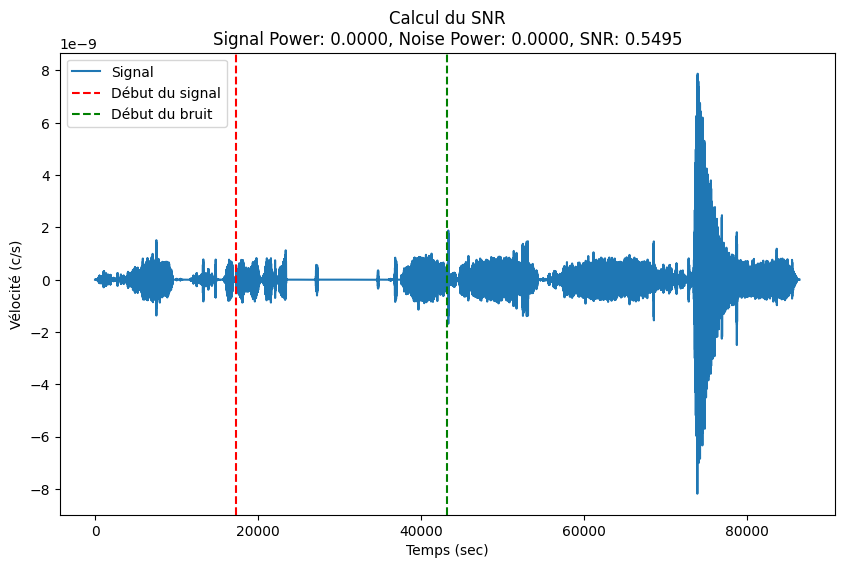

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

cat_directory = './data/lunar/training/data/S12_GradeA'
cat_file = cat_directory + '/xa.s12.00.mhz.1970-01-19HR00_evid00002.csv'
cat = pd.read_csv(cat_file)
print(cat.columns)

# Extraire les données de vélocité comme signal pour le calcul du SNR
signal = cat['velocity(m/s)'].values
time = cat['time_rel(sec)'].values

# Simuler les "triggers" pour définir une région d'événements
triggers = [int(len(signal) * 0.2), int(len(signal) * 0.5)]

# Calcul de la puissance du signal (sur toute la durée)
signal_power = np.mean(signal ** 2)

# Calcul de la puissance du bruit (après le premier événement)
noise = signal[triggers[1]:] - np.mean(signal[triggers[1]:])
noise_power = np.mean(noise ** 2)

# Calcul du SNR
snr = signal_power / noise_power

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(time, signal, label='Signal')
plt.axvline(x=time[triggers[0]], color='r', linestyle='--', label='Début du signal')
plt.axvline(x=time[triggers[1]], color='g', linestyle='--', label='Début du bruit')
plt.title(f'Calcul du SNR\nSignal Power: {signal_power:.4f}, Noise Power: {noise_power:.4f}, SNR: {snr:.4f}')
plt.xlabel('Temps (sec)')
plt.ylabel('Vélocité (c/s)')
plt.legend()
plt.show()